In [200]:
# print importing stuff

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import os

import glob

%matplotlib inline
warnings.filterwarnings('ignore')


In [201]:
df = pd.read_excel("data/data.xlsx")

df.head()

,Unnamed: 0,Booking number,Start,End,Participants,Adults,Participants (details),Experience,Product code,Status,...,Created,Created by,Last changed,Last changed by,Canceled,Canceled by,Add a full service Cryo-air facial with skincare treatment?,Would you like float audio?,Would you like lights on extra?,ID
0,0,2556005148807663,2020-05-17 10:30:00,2020-05-17 12:00:00,2,2,NaN,Weightless Luxury Float,R1A-STDFLOT,normal,...,2020-05-14 11:13:00,CUSTOMER,NaT,NaN,NaT,NaN,NaN,"Yes, ambient music for 15m","Yes, low for 15m",-8.561293e+18
1,1,2556005147366661,2020-05-15 16:30:00,2020-05-15 18:00:00,2,2,NaN,Weightless Luxury Float,R1A-STDFLOT,normal,...,2020-05-14 15:41:00,CUSTOMER,NaT,NaN,NaT,NaN,NaN,"Yes, ambient music for 60m","No, just dark after I get in...",8.655874e+18
2,2,2556005176711086,2020-05-17 13:30:00,2020-05-17 15:00:00,2,2,NaN,Weightless Luxury Float,R1A-STDFLOT,normal,...,2020-05-17 12:49:00,CUSTOMER,NaT,NaN,NaT,NaN,NaN,"Yes, ambient music for 30m","No, just dark after I get in...",-9.053044e+18
3,3,2556005178902031,2020-05-17 18:00:00,2020-05-17 19:30:00,1,1,NaN,Weightless Luxury Float,R1A-STDFLOT,normal,...,2020-05-17 17:52:00,Lobby,NaT,NaN,NaT,NaN,NaN,"No, just quiet, please","No, just dark after I get in...",0.000000e+00
4,4,2556005207608961,2020-05-20 16:30:00,2020-05-20 18:00:00,2,2,NaN,Weightless Luxury Float,R1A-STDFLOT,normal,...,2020-05-20 12:00:00,Manager,NaT,NaN,NaT,NaN,NaN,"No, just quiet, please","No, just dark after I get in...",-4.976860e+18


In [202]:
#creating fields for the RFM table

#order date
df['Order Date'] = df['Created']
#order ID
df['Order ID'] = df['Booking number']
#profit
df['Profit'] = df['Total net']

# Creation of RFM table
RFM table where the ID, order date and profit (total net) are setup 

In [203]:
#Step 1: Create RFM Features for each customers
df_RFM = df.groupby('ID').agg({'Order Date': lambda y: (df['Order Date'].max().date() - y.max().date()).days,
                                        'Order ID': lambda y: len(y.unique()),  
                                        'Profit': lambda y: round(y.sum(),2)})
df_RFM.columns = ['Recency', 'Frequency', 'Monetary']
df_RFM = df_RFM.sort_values('Monetary', ascending=False)
df_RFM.head()

,Recency,Frequency,Monetary
ID,,,
0.000000e+00,0,46,325934.58
1.418898e+17,4,3,32027.04
-2.947883e+18,27,4,22729.74
-3.913870e+18,7,2,22418.91
5.896166e+18,42,5,21846.85


The quanties are created

In [204]:
#Step 2: # creating a segmented RFM table

quantiles = df_RFM.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

segmented_rfm = df_RFM


In [205]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [206]:
segmented_rfm['r_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles,))
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFMScore
ID,,,,,,,
0.000000e+00,0,46,325934.58,1,1,1,111
1.418898e+17,4,3,32027.04,1,1,1,111
-2.947883e+18,27,4,22729.74,2,1,1,211
-3.913870e+18,7,2,22418.91,1,1,1,111
5.896166e+18,42,5,21846.85,3,1,1,311


## segementation map

In [207]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

#adding the mapping to the DF
segmented_rfm['DEF'] = segmented_rfm['r_quartile'].map(str) + df_RFM['f_quartile'].map(str)
segmented_rfm['DEF'] = segmented_rfm['DEF'].replace(segt_map, regex=True)
df_RFM.head(10)

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFMScore,DEF
ID,,,,,,,,
0.000000e+00,0,46,325934.58,1,1,1,111,hibernating
1.418898e+17,4,3,32027.04,1,1,1,111,hibernating
-2.947883e+18,27,4,22729.74,2,1,1,211,hibernating
-3.913870e+18,7,2,22418.91,1,1,1,111,hibernating
5.896166e+18,42,5,21846.85,3,1,1,311,about to sleep
-3.456012e+18,24,2,21351.36,2,1,1,211,hibernating
2.399557e+18,61,2,21351.36,4,1,1,411,promising
-2.073483e+18,7,2,21351.36,1,1,1,111,hibernating
8.363758e+18,64,1,21351.36,4,4,1,441,loyal customers


The distribution of customer in the DF is interesting, about half are almost lost customer, another big checku are loyal 

In [208]:
# Count the number of customers in each segment
segments_counts = df_RFM['DEF'].value_counts().sort_values(ascending=True)

# Create the horizontal bar chart using Plotly
fig = go.Figure()

fig.add_trace(go.Bar(
    y=segments_counts.index,
    x=segments_counts.values,
    orientation='h',
    marker=dict(
        color=['silver' if segment not in ['hibernating', 'at risk', 'loyal customer']
               else 'firebrick' if segment in ['hibernating', 'at risk']
        else 'green' for segment in segments_counts.index],
    ),
    text=[f'{int(value):,} ({int(value*100/segments_counts.sum())}%)'
          for value in segments_counts.values],
    textposition='inside',
    textfont=dict(color='white'),
))

fig.update_layout(
    title='Distribution of customers in segments',
    yaxis=dict(tickmode='array', tickvals=list(range(len(segments_counts))), ticktext=segments_counts.index),
    xaxis=dict(title='Number of Customers'),
    showlegend=False,
)

fig.show()
fig.write_image("output/fig1.png")

In [209]:
df = df_RFM
fig = px.histogram(df, x="Frequency", color="DEF")


fig.update_layout(
    title='Distribution Frequency')
fig.show()
fig.write_image("output/freq_hist.png")

# This is the start of clustering
The next charts are to see how many clusters of peole are there and how many will be used to plot. And this will serve as a way to confim the distrib above

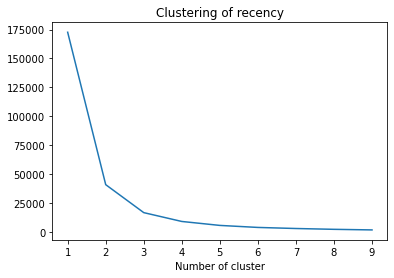

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFMScore,DEF
ID,,,,,,,,
0.0,0,46,325934.58,1,1,1,111,hibernating


In [210]:
from sklearn.cluster import KMeans
sse={}
CLU_recency = df_RFM[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(CLU_recency)
    CLU_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.title("Clustering of recency")
plt.show()
df_RFM.head(1)

In [211]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_RFM[['Recency']])
df_RFM['RecencyCluster'] = kmeans.predict(df_RFM[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_RFM = order_cluster('RecencyCluster', 'Recency',segmented_rfm,False)
df_RFM.head(1)

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFMScore,DEF,RecencyCluster
0,0,46,325934.58,1,1,1,111,hibernating,3


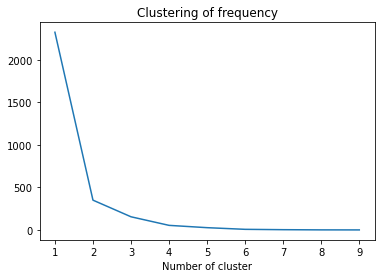

In [212]:
sse={}
CLU_frequency = df_RFM[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(CLU_frequency)
    CLU_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.title("Clustering of frequency")
plt.show()

In [213]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_RFM[['Frequency']])
df_RFM['FrequencyCluster'] = kmeans.predict(df_RFM[['Frequency']])

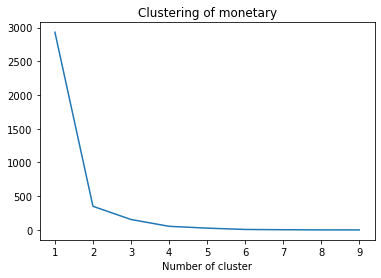

In [214]:
sse={}
CLU_monetary = df_RFM[['Monetary']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(CLU_frequency)
    CLU_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.title("Clustering of monetary")
plt.show()

In [215]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_RFM[['Monetary']])
df_RFM['MonetaryCluster'] = kmeans.predict(df_RFM[['Monetary']])
df_RFM.head(1)

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFMScore,DEF,RecencyCluster,FrequencyCluster,MonetaryCluster
0,0,46,325934.58,1,1,1,111,hibernating,3,1,1


In [216]:
#calculate overall score and use mean() to see details
df_RFM['OverallScore'] = df_RFM['RecencyCluster'] + df_RFM['FrequencyCluster'] + df_RFM['MonetaryCluster']
df_RFM.groupby('OverallScore')['Recency','Frequency','Monetary'].mean()

,Recency,Frequency,Monetary
OverallScore,,,
0,77.384615,1.076923,0.000769
1,53.681818,1.136364,0.000455
2,56.266667,1.200000,6215.618333
3,42.862745,1.313725,6537.873922
4,41.083333,1.333333,9587.591389
5,17.250000,2.875000,17605.273250
6,10.631579,1.473684,8829.043158
7,3.500000,3.000000,24909.920000
8,5.333333,7.000000,7867.873333


In [217]:
df_RFM.groupby('OverallScore')['Recency', 'Frequency', 'Monetary'].count()

,Recency,Frequency,Monetary
OverallScore,,,
0,13,13,13
1,22,22,22
2,30,30,30
3,51,51,51
4,36,36,36
5,40,40,40
6,38,38,38
7,2,2,2
8,3,3,3


In [218]:
df_RFM['Segment'] = 'Low-Value'
df_RFM.loc[df_RFM['OverallScore']>3,'Segment'] = 'Mid-Low-Value' 
df_RFM.loc[df_RFM['OverallScore']>5,'Segment'] = 'Mid-High-Value' 
df_RFM.loc[df_RFM['OverallScore']>7,'Segment'] = 'High-Value' 
df_RFM

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFMScore,DEF,RecencyCluster,FrequencyCluster,MonetaryCluster,OverallScore,Segment
0,0,46,325934.58,1,1,1,111,hibernating,3,1,1,5,Mid-Low-Value
1,4,3,32027.04,1,1,1,111,hibernating,3,2,2,7,Mid-High-Value
2,7,2,22418.91,1,1,1,111,hibernating,3,0,2,5,Mid-Low-Value
3,7,2,21351.36,1,1,1,111,hibernating,3,0,2,5,Mid-Low-Value
4,3,3,17792.80,1,1,1,111,hibernating,3,2,2,7,Mid-High-Value
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,79,1,0.00,4,4,4,444,loyal customers,0,0,0,0,Low-Value
231,67,1,0.00,4,4,4,444,loyal customers,0,0,0,0,Low-Value
232,68,1,0.00,4,4,4,444,loyal customers,0,0,0,0,Low-Value
233,81,1,0.00,4,4,4,444,loyal customers,0,0,0,0,Low-Value


In [219]:
#large outlier at position 0, skipping it
df_RFM = df_RFM.drop(df_RFM.index[0])
df_RFM


,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFMScore,DEF,RecencyCluster,FrequencyCluster,MonetaryCluster,OverallScore,Segment
1,4,3,32027.04,1,1,1,111,hibernating,3,2,2,7,Mid-High-Value
2,7,2,22418.91,1,1,1,111,hibernating,3,0,2,5,Mid-Low-Value
3,7,2,21351.36,1,1,1,111,hibernating,3,0,2,5,Mid-Low-Value
4,3,3,17792.80,1,1,1,111,hibernating,3,2,2,7,Mid-High-Value
5,2,1,16013.52,1,4,1,141,at risk,3,0,2,5,Mid-Low-Value
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,79,1,0.00,4,4,4,444,loyal customers,0,0,0,0,Low-Value
231,67,1,0.00,4,4,4,444,loyal customers,0,0,0,0,Low-Value
232,68,1,0.00,4,4,4,444,loyal customers,0,0,0,0,Low-Value
233,81,1,0.00,4,4,4,444,loyal customers,0,0,0,0,Low-Value


# Visualisations

In [220]:
# Define a function to create scatter plots for different segments
def create_segment_scatter(tx_graph, x_column, y_column, x_title, y_title):
    plot_data = []
    markers = {'Low-Value': {'color': 'blue', 'size': 7},
               'Mid-High-Value': {'color': 'yellow', 'size': 7},
               'Mid-Low-Value': {'color': 'green', 'size': 9},
               'High-Value': {'color': 'red', 'size': 11}}
  
    
    for segment, properties in markers.items():
        scatter_data = go.Scatter(
            x=tx_graph.query(f"Segment == '{segment}'")[x_column],
            y=tx_graph.query(f"Segment == '{segment}'")[y_column],
            mode='markers',
            name=segment,
            marker=dict(
                size=properties['size'],
                line=dict(width=1),
                color=properties['color'],
                opacity=0.8
            )
        )
        plot_data.append(scatter_data)

    plot_layout = go.Layout(
        xaxis={'title': x_title},
        yaxis={'title': y_title},
        title='Segments'
    )
    fig = go.Figure(data=plot_data, layout=plot_layout)
    fig.write_image(f"output/{x_column}_vs_{y_column}.png")  # Save the plot as an image
    fig.show()

# Example usage:
# Revenue vs Frequency
tx_graph_revenue_frequency = df_RFM.query("Monetary > 0 and Frequency > 0")
create_segment_scatter(tx_graph_revenue_frequency, 'Frequency', 'Monetary', 'Frequency', 'Monetary')

# Revenue vs Recency
tx_graph_revenue_recency = df_RFM.query("Monetary < 50000 and Frequency < 2000")
create_segment_scatter(tx_graph_revenue_recency, 'Recency', 'Monetary', 'Recency', 'Monetary')

# Revenue vs Frequency
tx_graph_recency_frequency = df_RFM.query("Monetary < 50000 and Frequency < 2000")
create_segment_scatter(tx_graph_recency_frequency, 'Recency', 'Frequency', 'Recency', 'Frequency')


In [221]:
import plotly.express as px
count = df_RFM.count()
fig = px.scatter_3d(df_RFM, x='r_quartile', y='f_quartile', z='m_quartile', color='DEF',
                    hover_data=['Segment'],
                    size='Monetary',
                    labels={
                        "r_quartile": "Recency Score",
                        "f_quartile": "Frequency Score",
                        "m_quartile": "Monetary Score"
                    },
                    )
#fig.update_layout(zaxis_title="New X-axis Title")
fig.write_image("output/fig3d.png")
fig.show()
#this 3d chart doesnt really show anything, the amount of money in hibernating customer with low score undermines the resti 

In [222]:
fig = px.treemap(df_RFM, path=['DEF'],
                 color='Monetary',
                 color_continuous_scale='RdBu'
                 #color_continuous_midpoint=np.average(map_df['productsSold'], weights=map_df['productsPassRate']) MonetaryCluster
                 )
fig.update_layout(
    title={
        'text': "A represenation of the users segmentation and its segments",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.data[0].textinfo = 'label+percent root'
#'label', 'text', 'value', 'current path', 'percent root', 'percent entry', 'percent parent'
fig.write_image("Output/treemap.png")
fig.show()

# Customer life value

In [223]:
df_RFM.head(2)

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFMScore,DEF,RecencyCluster,FrequencyCluster,MonetaryCluster,OverallScore,Segment
1,4,3,32027.04,1,1,1,111,hibernating,3,2,2,7,Mid-High-Value
2,7,2,22418.91,1,1,1,111,hibernating,3,0,2,5,Mid-Low-Value


In [224]:
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes import *

data = summary_data_from_transaction_data(df_6m, 'ID', 'Order Date', monetary_value_col='Profit', observation_period_end='2014-12-31')
data.head()

NameError: name 'df_6m' is not defined

In [ ]:
df_RFM['Frequency'].plot(kind='hist', bins=50)
print(data['frequency'].describe())
print(sum(df_RFM['Frequency'] == 0)/float(len(df_RFM)))

# Churn Rate


In [225]:
df = pd.read_excel("data/data.xlsx")
#creating fields for the RFM table

#order date
df['Order Date'] = df['Created']
#order ID
df['Order ID'] = df['Booking number']
#profit
df['Profit'] = df['Total net']
df.head(4)

,Unnamed: 0,Booking number,Start,End,Participants,Adults,Participants (details),Experience,Product code,Status,...,Last changed by,Canceled,Canceled by,Add a full service Cryo-air facial with skincare treatment?,Would you like float audio?,Would you like lights on extra?,ID,Order Date,Order ID,Profit
0,0,2556005148807663,2020-05-17 10:30:00,2020-05-17 12:00:00,2,2,NaN,Weightless Luxury Float,R1A-STDFLOT,normal,...,NaN,NaT,NaN,NaN,"Yes, ambient music for 15m","Yes, low for 15m",-8.561293e+18,2020-05-14 11:13:00,2556005148807663,12099.10
1,1,2556005147366661,2020-05-15 16:30:00,2020-05-15 18:00:00,2,2,NaN,Weightless Luxury Float,R1A-STDFLOT,normal,...,NaN,NaT,NaN,NaN,"Yes, ambient music for 60m","No, just dark after I get in...",8.655874e+18,2020-05-14 15:41:00,2556005147366661,14234.24
2,2,2556005176711086,2020-05-17 13:30:00,2020-05-17 15:00:00,2,2,NaN,Weightless Luxury Float,R1A-STDFLOT,normal,...,NaN,NaT,NaN,NaN,"Yes, ambient music for 30m","No, just dark after I get in...",-9.053044e+18,2020-05-17 12:49:00,2556005176711086,14234.24
3,3,2556005178902031,2020-05-17 18:00:00,2020-05-17 19:30:00,1,1,NaN,Weightless Luxury Float,R1A-STDFLOT,normal,...,NaN,NaT,NaN,NaN,"No, just quiet, please","No, just dark after I get in...",0.000000e+00,2020-05-17 17:52:00,2556005178902031,7117.12


In [226]:
import datetime as dt
# Function that converts date to year month
def get_month(x):
    return dt.datetime(x.year, x.month, 1)
# Create the invoicemonth period column

df['InvoiceMonth'] = df['Order Date'].apply(get_month)


In [227]:
# Group by customerID and select only the invoicemonth column
grouping = df.groupby('ID')['InvoiceMonth']

# Take the earliest date of each customer and assign it back to the orignal dataset
df['CohortMonth'] = grouping.transform('min')

In [228]:
# This function gets us the integer value of year and month
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

# Get the integers for the date parts from the 'InvoiceMonth' column
invoice_year, invoice_month = get_date_int(df, 'InvoiceMonth')

# Get the integers for date parts from the 'Cohortmonth' column
cohort_year, cohort_month = get_date_int(df, 'CohortMonth')

# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Extract the difference in months from all previous values
df['CohortIndex'] = years_diff * 12 + months_diff + 1
df.head()


,Unnamed: 0,Booking number,Start,End,Participants,Adults,Participants (details),Experience,Product code,Status,...,Add a full service Cryo-air facial with skincare treatment?,Would you like float audio?,Would you like lights on extra?,ID,Order Date,Order ID,Profit,InvoiceMonth,CohortMonth,CohortIndex
0,0,2556005148807663,2020-05-17 10:30:00,2020-05-17 12:00:00,2,2,NaN,Weightless Luxury Float,R1A-STDFLOT,normal,...,NaN,"Yes, ambient music for 15m","Yes, low for 15m",-8.561293e+18,2020-05-14 11:13:00,2556005148807663,12099.10,2020-05-01,2020-05-01,1
1,1,2556005147366661,2020-05-15 16:30:00,2020-05-15 18:00:00,2,2,NaN,Weightless Luxury Float,R1A-STDFLOT,normal,...,NaN,"Yes, ambient music for 60m","No, just dark after I get in...",8.655874e+18,2020-05-14 15:41:00,2556005147366661,14234.24,2020-05-01,2020-05-01,1
2,2,2556005176711086,2020-05-17 13:30:00,2020-05-17 15:00:00,2,2,NaN,Weightless Luxury Float,R1A-STDFLOT,normal,...,NaN,"Yes, ambient music for 30m","No, just dark after I get in...",-9.053044e+18,2020-05-17 12:49:00,2556005176711086,14234.24,2020-05-01,2020-05-01,1
3,3,2556005178902031,2020-05-17 18:00:00,2020-05-17 19:30:00,1,1,NaN,Weightless Luxury Float,R1A-STDFLOT,normal,...,NaN,"No, just quiet, please","No, just dark after I get in...",0.000000e+00,2020-05-17 17:52:00,2556005178902031,7117.12,2020-05-01,2020-05-01,1
4,4,2556005207608961,2020-05-20 16:30:00,2020-05-20 18:00:00,2,2,NaN,Weightless Luxury Float,R1A-STDFLOT,normal,...,NaN,"No, just quiet, please","No, just dark after I get in...",-4.976860e+18,2020-05-20 12:00:00,2556005207608961,0.01,2020-05-01,2020-05-01,1


In [229]:
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
# Count the number of unique values per Customer ID
cohort_data = grouping['ID'].apply(pd.Series.nunique).reset_index()

# Create a pivot
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='ID')

# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis=0)*100

In [230]:

# Create list of month names for visualization
month_list = retention.reset_index()['CohortMonth']

def get_month_name(x):
    return dt.datetime.strftime(x, '%b-%y')

month_list = month_list.apply(get_month_name)

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
    z=retention.values,
    x=retention.columns,
    y=month_list,
    colorscale='RdBu',
    colorbar=dict(title='Retention in %'),
    hoverongaps=False,

))

# Update layout
fig.update_layout(
    title='Retention by Monthly Cohorts',
    xaxis_title='Cohort Index',
    yaxis_title='Cohort Month',
)

# Show the plot
fig.write_image("Output/retention_monthly.png")
fig.show()


In [231]:
import plotly.graph_objects as go

# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = df.groupby(['CohortMonth', 'CohortIndex'])

# Calculate the average of the 'Price' column
cohort_data = grouping['Total net'].mean()

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

# Create a pivot
average_price = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Total net')
average_price.index = average_price.index.date

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
    z=average_price.values,
    x=average_price.columns,
    y=average_price.index,
    colorscale='RdBu',
    colorbar=dict(title='Average Spend'),
    hoverongaps=False,
    text=average_price.values  # Set the z-values as text
))

# Update layout
fig.update_layout(
    title='Average Spend by Monthly Cohorts',
    xaxis_title='Cohort Index',
    yaxis_title='Cohort Month',
)

#fig = px.imshow(average_price, text_auto=True, aspect="auto")
# Show the plot
fig.write_image("Output/spending_monthly_cohort.png")
fig.show()
    

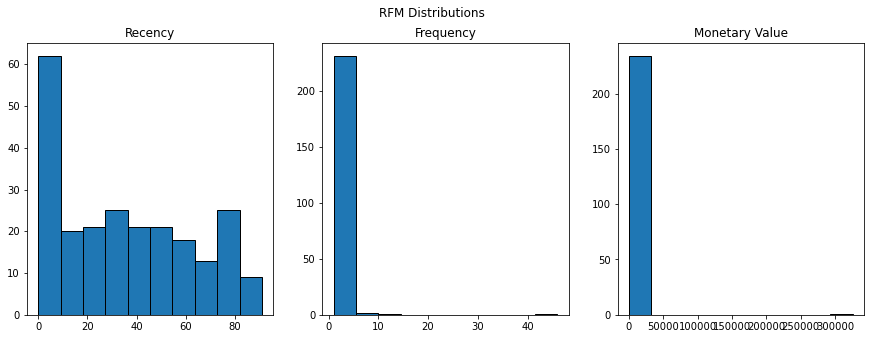

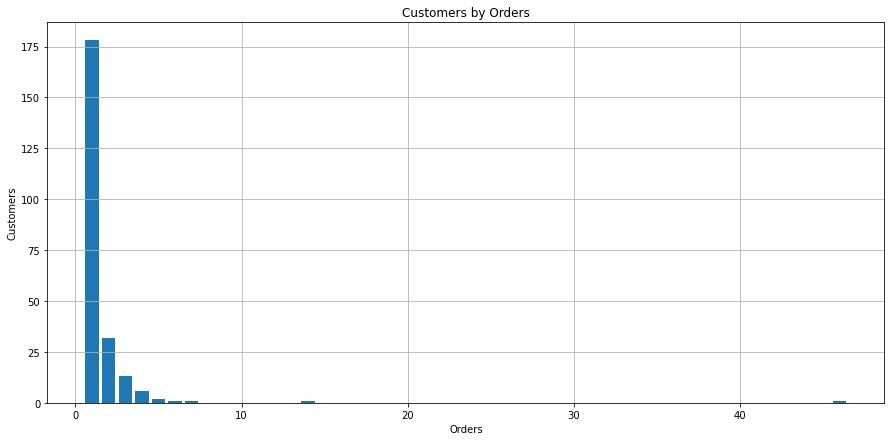

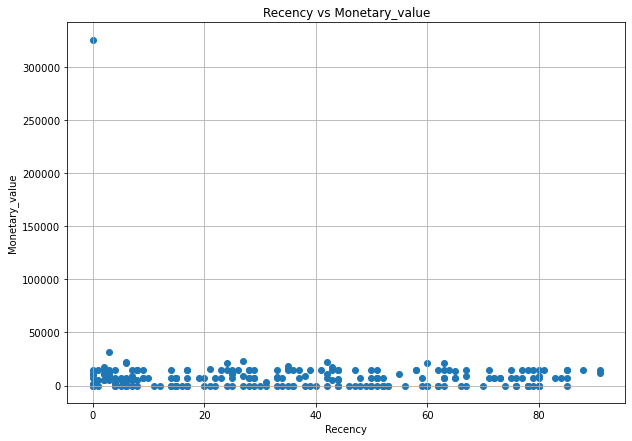

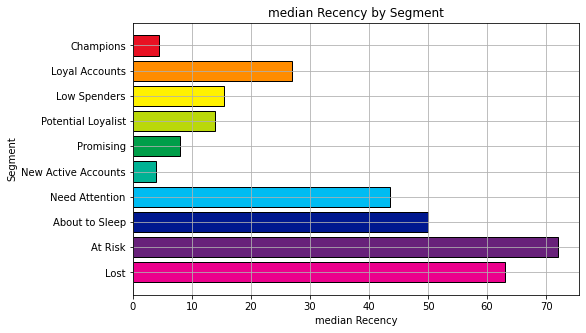

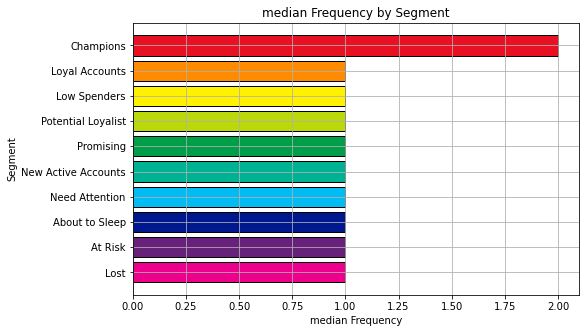

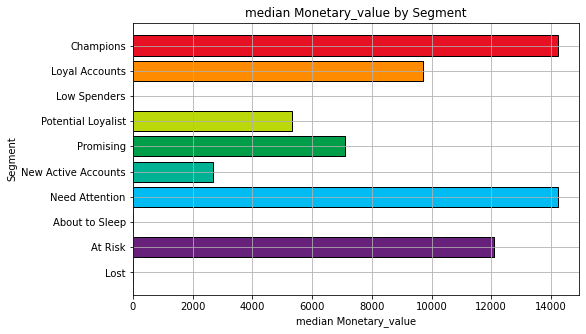

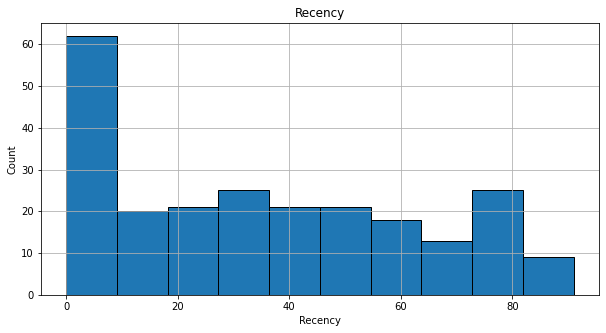

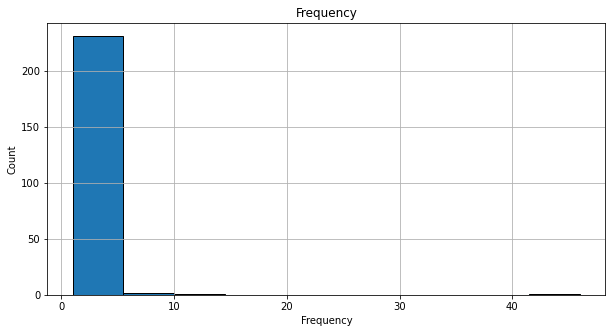

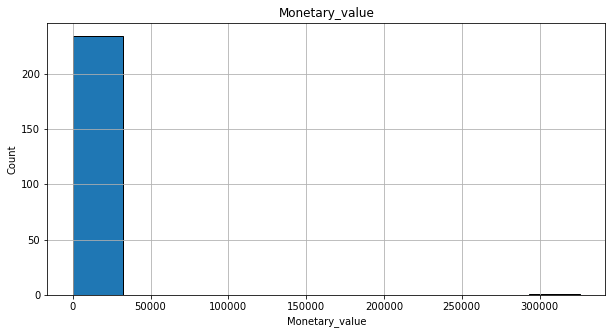

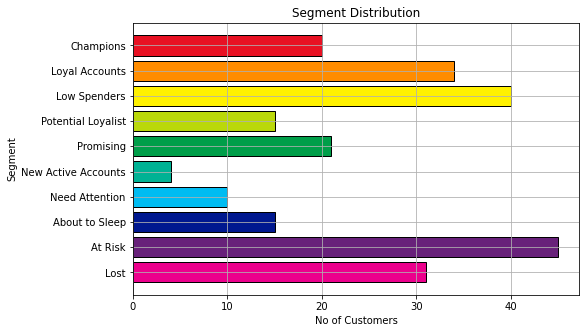

,ID,recency,frequency,monetary_value,r,f,m,rfm_score,segment
0,0,0,46,325934.56,5,5,5,555,Champions
1,1.41889841192585e+17,3,3,32027.04,5,5,5,555,Champions
2,-1.730764956960466e+17,2,3,17792.80,5,5,5,555,Champions
3,-8.718529675837011e+18,3,2,12454.96,5,5,4,554,Champions
4,5.977680303343795e+18,0,4,10450.44,5,5,4,554,Champions
5,8.378726598837343e+18,3,2,8738.74,5,5,4,554,Champions
6,-2.073482712557262e+,6,2,21351.36,5,4,5,545,Champions
7,-3.913870139141671e+18,6,2,22418.84,5,4,5,545,Champions
8,8.828548310277758e+18,3,1,14234.24,5,4,5,545,Champions
9,9.468809488193865e+17,1,1,14234.24,5,4,5,545,Champions


In [232]:
# could have done it with this library... output in plt, not as sexy as plotly...

from rfm import RFM

r = RFM(df, customer_id='ID', transaction_date='Order Date', amount='Profit')
r.rfm_table
r.segment_table
r.plot_rfm_histograms()
r.plot_rfm_order_distribution()
r.plot_versace_plot(column1='recency',column2='monetary_value')
r.plot_distribution_by_segment(column='recency',take='median')
r.plot_distribution_by_segment(column='frequency',take='median')
r.plot_distribution_by_segment(column='monetary_value',take='median')
r.plot_column_distribution(column='recency')
r.plot_column_distribution(column='frequency')
r.plot_column_distribution(column='monetary_value')
r.plot_segment_distribution()
r.find_customers('Champions')